# Setup

In [60]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [78]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [79]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

# Hyperparameters

In [80]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

# Load datasets and loaders

In [81]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [82]:
print(train_data.data.shape)
print(train_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [83]:
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Build Model

In [84]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.conv_and_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
        )
        self.max_pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )
#         self.log_softmax = nn.LogSoftmax(1)
        
    def forward(self, x):
        x = self.conv_and_relu_stack(x)
        x = self.max_pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        output = self.fc_layers(x)
        return output

In [85]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (conv_and_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Optimization Loop

In [87]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = F.log_softmax(model(X), dim=1)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            
def test_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = F.log_softmax(model(X), dim=1)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test error: \n Accuracy: {(100*correct):>0.1f}%, Avg_loss: {test_loss:>8f} \n")
    writer.add_scalar(
        'test loss',
        test_loss,
        epoch * num_batches
    )
    writer.add_scalar(
        'Accuracy(%)',
        correct * 100,
        epoch * num_batches
    )

In [88]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn, optimizer, epoch)
print("Done!")

Epoch 1
-------------------------
loss: 2.298680  [   64/60000]
loss: 2.288710  [ 6464/60000]
loss: 2.267956  [12864/60000]
loss: 2.253999  [19264/60000]
loss: 2.243592  [25664/60000]
loss: 2.183565  [32064/60000]
loss: 2.176945  [38464/60000]
loss: 2.072713  [44864/60000]
loss: 2.041702  [51264/60000]
loss: 1.921990  [57664/60000]
Test error: 
 Accuracy: 43.3%, Avg_loss: 1.887127 

Epoch 2
-------------------------
loss: 1.905268  [   64/60000]
loss: 1.813328  [ 6464/60000]
loss: 1.539150  [12864/60000]
loss: 1.553203  [19264/60000]
loss: 1.338171  [25664/60000]
loss: 1.288636  [32064/60000]
loss: 1.299567  [38464/60000]
loss: 1.115200  [44864/60000]
loss: 1.264999  [51264/60000]
loss: 1.163742  [57664/60000]
Test error: 
 Accuracy: 61.0%, Avg_loss: 1.092618 

Epoch 3
-------------------------
loss: 1.088454  [   64/60000]
loss: 1.180254  [ 6464/60000]
loss: 0.934815  [12864/60000]
loss: 1.112937  [19264/60000]
loss: 1.006811  [25664/60000]
loss: 0.899252  [32064/60000]
loss: 1.014826

# Visualizing with Tensorboard

In [51]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Image

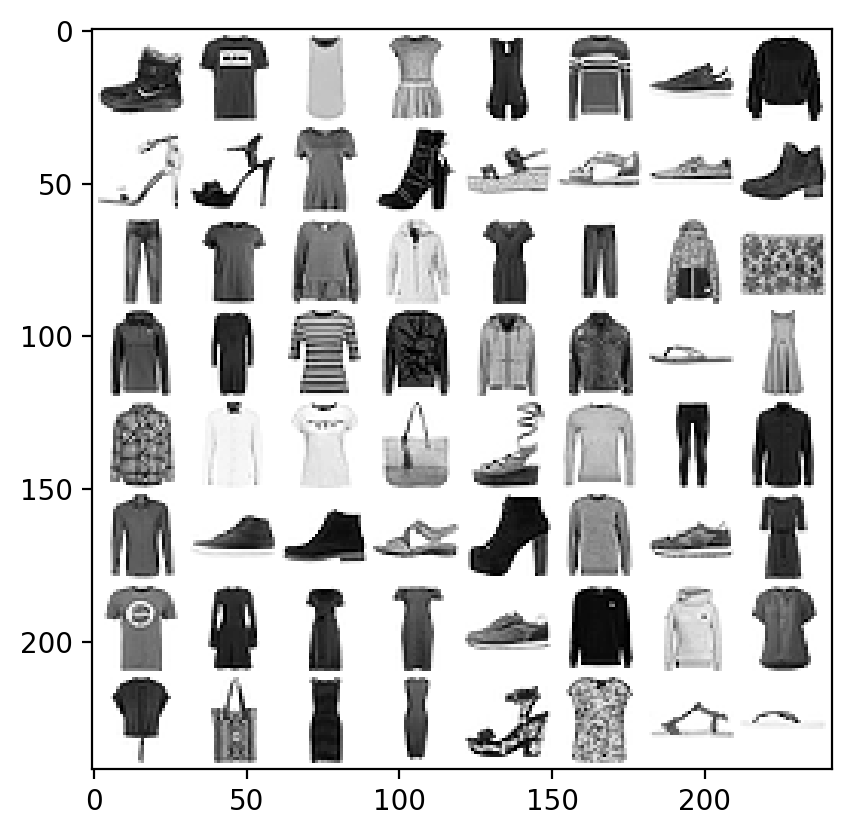

In [52]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('four_fashion_mnist_images', img_grid)

# Graph

In [53]:
writer.add_graph(model, images.to(device))
writer.close()

# Projector

In [54]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(train_data.data, train_data.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

# PR Curves

In [89]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        class_probs_batch = F.softmax(model(images), dim=1)

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat(class_probs)
test_label = torch.cat(class_label)

print(test_probs.shape)
print(test_label.shape)

torch.Size([10000, 10])
torch.Size([10000])


In [90]:
test_probs

tensor([[8.6038e-06, 1.6351e-07, 9.4796e-07,  ..., 4.7918e-01, 2.1797e-03,
         4.9604e-01],
        [2.1688e-02, 8.8710e-07, 7.1109e-01,  ..., 3.9442e-07, 8.3702e-06,
         8.1034e-07],
        [1.6738e-04, 9.9917e-01, 3.4318e-06,  ..., 8.5449e-08, 8.4329e-07,
         3.3434e-09],
        ...,
        [1.4066e-01, 2.1168e-03, 3.7101e-02,  ..., 2.8123e-03, 5.9777e-01,
         4.9633e-03],
        [2.1157e-06, 9.9520e-01, 1.1094e-07,  ..., 2.3975e-05, 4.4443e-08,
         3.6858e-06],
        [2.8626e-05, 1.8130e-06, 7.0202e-05,  ..., 2.1487e-01, 3.4744e-03,
         1.7519e-02]], device='mps:0')

In [91]:
# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(
        classes[class_index],
        tensorboard_truth,
        tensorboard_probs,
        global_step=global_step,
    )
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)